In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from sklearn.metrics import mean_squared_error

import pickle
import time

from IPython.display import clear_output

from utils import get_views_coord
from utils import test_val_train
from utils import sample_conflict_timeline
from utils import get_hyper_priors
from utils import predict
from utils import plot_predictions
from utils import get_mse

start_time = time.time()

Todo:

4) Make final classifier
4) Make ready to run eksperiments on comuterome.   

Bonus) Also don't forget you only do sb right now. Would be nice to also have ns and os.

Q's) 
- why don't they use 1989 for train?
- Don't they say 36 months? But there are only 36 in train and val? Is that because they say 36 months into the furture? 



old note (maybe still relevatn):
So, you wnat to make it as a function that can by iterated over, shitching C and shortterm cov - and maybe even priors. It needs to give out mse and save it. You also need to be able to survey/plot the models you afterwards find most interesting.

remember you are only running on ged_sb_best. but that is an experiament perhaps to run...
- Do they exhipist different lenght scale?
- Are one easier to predict than others?
- Can they inform each other?
- Does it make any difference if we pool them?
->> But keep in mind how much you want wich this paper and that the main concerne is to make it comparebal to ViEWS; which uses sb in the presented paper..
-> But it would still be super nice to know, and to ahve in the appendix..

In [2]:
# get df:
df = get_views_coord()

# get train and val/test id:
train_id, val_id = test_val_train(df)
#train_id, test_id = test_val_train(df, test_time = True)

# X, y, X_test, y_test, idx, idx_test = sample_conflict_timeline(df = df, train_id = train_id, test_id = val_id, C = 100, N = None, get_index= True)

Train from 1/1990 trough 12/2011 (264)
Val from 1/2012 trough 12/2014 (36)
Test time from 1/2015 trough 12/2017 (36)
(Test=False, so test set not outputted)



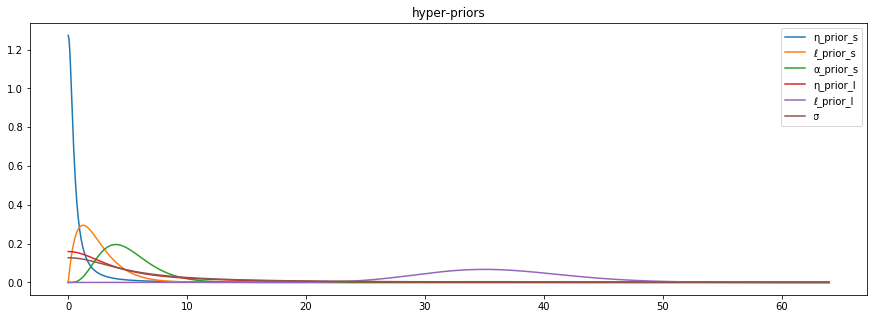

In [3]:
hyper_priors_dict = get_hyper_priors(plot = True)

In [4]:
# 43.3 minutes with 148 time-lines
#C = 100 # -> 6 obs
# C = 64 # -> 12 obs
# C = 40 # -> 38 obs
C = 32 # -> 60 obs
# C = 24 # -> 87 obs
# C = 16 # -> 158 obs

N=None
seed = 42
dem = False

hps = get_hyper_priors(plot = False)

with pm.Model() as model:

    # short term trend/irregularities ---------------------------------
    ℓ_s = pm.Gamma("ℓ_s", alpha=hps['ℓ_alpha_s'] , beta=hps['ℓ_beta_s'])
    η_s = pm.HalfCauchy("η_s", beta=hps['η_beta_s'])
    α_s = pm.Gamma("α_s", alpha=hps['α_alpha_s'], beta=hps['α_beta_s']) #for Rational Quadratic Kernel. Ignore for Quad or Matern 

    # mean and kernal for short term trend
    mean_s =  pm.gp.mean.Zero()
    #cov_s = η_s ** 2 * pm.gp.cov.RatQuad(1, ℓ_s, α_s) # this seems to help alot when you split the trends below
    cov_s = η_s ** 2 * pm.gp.cov.ExpQuad(1, ℓ_s) # this seems to help alot when you split the trends below
    # so this needs to be some thng you can vary over in a loop

    # GP short term trend 
    gp_s = pm.gp.Marginal(mean_func = mean_s, cov_func=cov_s)


    # long term trend -------------------------------------------------
    ℓ_l = pm.Gamma("ℓ_l", alpha=hps['ℓ_alpha_l'] , beta=hps['ℓ_beta_l'])
    η_l = pm.HalfCauchy("η_l", beta=hps['η_beta_l'])
    
    # mean and kernal for long term trend
    mean_l =  pm.gp.mean.Zero()
    cov_l = η_l **2 * pm.gp.cov.ExpQuad(1, ℓ_l) # Cov func.
    
    # GP short term trend 
    gp_l = pm.gp.Marginal(mean_func = mean_l, cov_func=cov_l)


    # noise (constant "white noise") -----------------------------------
    σ = pm.HalfCauchy("σ", beta=hps['σ_beta'])


    # sample and split X,y ---------------------------------------------  
    X, y, _, _ = sample_conflict_timeline(df = df, train_id = train_id, test_id = val_id, C = 100, N = None)

    # Full GP ----------------------------------------------------------
    gp = gp_s + gp_l

    # sample:
    for i in range(y.shape[1]):
        
        print(f'Time-line {i+1}/{y.shape[1]} in the works...') 
        clear_output(wait=True)

        y_ = gp.marginal_likelihood(f'y_{i}', X=X[:,i][:,None], y=y[:,i], noise= σ)
        
    
    mp = pm.find_MAP()


In [5]:
pd.DataFrame(
    {
        "Parameter": ["ℓ_s", "η_s", "α_s", "ℓ_l", "η_l", "σ"],
        "Value at MAP": [float(mp["ℓ_s"]), float(mp["η_s"]), float(mp["α_s"]), float(mp["ℓ_l"]), float(mp["η_l"]), float(mp["σ"])],
    }
)

,Parameter,Value at MAP
0,ℓ_s,2.690282
1,η_s,0.524803
2,α_s,3.999615
3,ℓ_l,35.393876
4,η_l,1.300028
5,σ,0.914842


In [6]:
end_time = time.time()
run_time = end_time - start_time

string = f'Run for {run_time/60:.3} minutes with {y.shape[1]} time-lines'
print(string)

Run for 2.5 minutes with 6 time-lines


In [7]:
df_new = predict(df = df, train_id = train_id, test_id = val_id, mp = mp, gp = gp, gp_s = gp_s, gp_l = gp_l, σ=σ, C=16)

Time-line 158/158 in the works...


In [8]:
df_merged = pd.merge(df_new, df[['id', 'pg_id','year','gwcode', 'xcoord', 'ycoord','ged_best_sb']], how = 'left', on = 'id') # Should merge all but this is fine for now.

In [18]:
df.columns

Index(['id', 'pg_id', 'month_id', 'year', 'month', 'gwcode', 'ged_dummy_sb',
       'ged_count_sb', 'ged_best_sb', 'ged_dummy_ns', 'ged_count_ns',
       'ged_best_ns', 'ged_dummy_os', 'ged_count_os', 'ged_best_os', 'xcoord',
       'ycoord', 'ged_best'],
      dtype='object')

In [9]:
# plot_predictions(df_merged = df_merged)

In [10]:
mse_resutls_df, mse_dict = get_mse(df_merged = df_merged, train_id = train_id, test_id = val_id)
mse_resutls_df

,Gps,MSE insample (mean),MSE insample (sd),MSE outsample (mean),MSE outsample (sd)
0,Full,0.226833,0.229263,0.622250,0.897463
1,Short,0.362851,0.650964,0.737934,1.362208
2,long,0.305408,0.324580,0.624475,0.900826


In [11]:
df_merged

,id,X,y,train,mu,mu_s,mu_l,var,var_s,var_l,pg_id
0,122784145,121,0.000000,1,0.041041,-4.587173e-02,0.086913,0.203207,0.195400,0.178398,153714
1,121979737,121,0.000000,1,0.007187,-6.933420e-03,0.014121,0.203207,0.195400,0.178398,151633
2,119457613,121,0.000000,1,0.005686,-4.898510e-03,0.010584,0.203207,0.195400,0.178398,145149
3,119499721,121,0.000000,1,0.000000,0.000000e+00,0.000000,0.203207,0.195400,0.178398,145179
4,119398081,121,0.000000,1,0.000000,0.000000e+00,0.000000,0.203207,0.195400,0.178398,145108
...,...,...,...,...,...,...,...,...,...,...,...
47395,113822700,420,0.693147,0,0.014684,9.306626e-43,0.014684,1.432492,0.275418,1.157074,130046
47396,113784948,420,0.000000,0,-0.013113,-8.223881e-42,-0.013113,1.432492,0.275418,1.157074,130020
47397,114044856,420,0.693147,0,0.000250,-4.197209e-41,0.000250,1.432492,0.275418,1.157074,130739
47398,114046308,420,0.000000,0,0.439625,-2.512219e-40,0.439625,1.432492,0.275418,1.157074,130740


# new shit: 
### need to check to performance af a classsifier.
Stuff needs to get into funcitons and get nuice and all that jazz

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [13]:

# call that df something else asap... or just keep as merged...

df_merged.sort_values(['pg_id', 'X'], inplace= True)
df_merged['mu_l_slope'] = df_merged.groupby('pg_id')['mu_l'].transform(np.gradient)
df_merged['mu_l_acc'] = df_merged.groupby('pg_id')['mu_l_slope'].transform(np.gradient)
df_merged['mu_l_mass'] = df_merged.groupby('pg_id')['mu_l'].transform(np.cumsum)
# df_test['mu_mass'] = df_test.groupby('pg_id')['mu'].transform(np.trapz, axis = -1)

# norm mass 0-1
df_merged['mu_l_mass'] = (df_merged['mu_l_mass'] - df_merged['mu_l_mass'].min())/(df_merged['mu_l_mass'].max() - df_merged['mu_l_mass'].min())

<Figure size 1440x576 with 0 Axes>

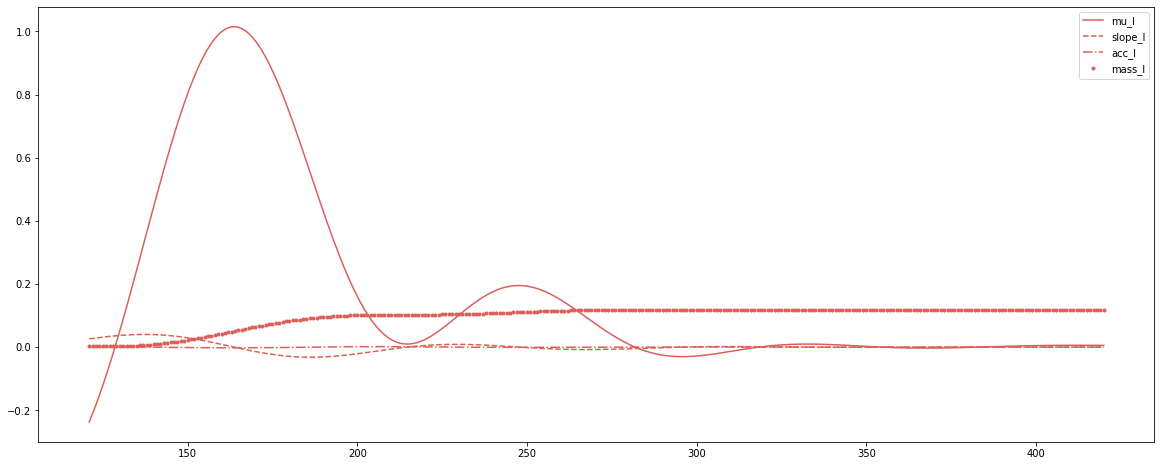

In [14]:
colors = sns.color_palette('hls', len(df_merged['pg_id'].unique()))
plt.figure(figsize=[20,8])


for i, j in  enumerate(df_merged['pg_id'].unique()[0:1]):
    plt.figure(figsize=[20,8])

    plt.plot(df_merged[df_merged['pg_id'] == j]['X'], df_merged[df_merged['pg_id'] == j]['mu_l'], '-',color = colors[i], label = 'mu_l')
    
    plt.plot(df_merged[df_merged['pg_id'] == j]['X'], df_merged[df_merged['pg_id'] == j]['mu_l_slope'], '--', color = colors[i], label = 'slope_l')

    plt.plot(df_merged[df_merged['pg_id'] == j]['X'], df_merged[df_merged['pg_id'] == j]['mu_l_acc'], '-.', color = colors[i], label = 'acc_l')


    plt.plot(df_merged[df_merged['pg_id'] == j]['X'], df_merged[df_merged['pg_id'] == j]['mu_l_mass'], '.', color = colors[i], label = 'mass_l')


    plt.legend()
    plt.show()



In [15]:
X_train = df_merged[df_merged['id'].isin(train_id)][['mu_l', 'mu_l_slope', 'mu_l_acc', 'mu_l_mass']] 
y_train = (df_merged[df_merged['id'].isin(train_id)]['y'] > 0) * 1

X_test = df_merged[df_merged['id'].isin(val_id)][['mu_l', 'mu_l_slope', 'mu_l_acc', 'mu_l_mass']] 
y_test = (df_merged[df_merged['id'].isin(val_id)]['y'] > 0) * 1

# totally vanilla - just indicative
model = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=8, random_state=42)
#model = AdaBoostClassifier(n_estimators=100, random_state=42)
#model = LogisticRegression()

model.fit(X_train, y_train)

y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

AUC_train = metrics.roc_auc_score(y_train, y_train_pred)
AP_train = metrics.average_precision_score(y_train, y_train_pred)
BS_train = metrics.brier_score_loss(y_train, y_train_pred)

AUC_test = metrics.roc_auc_score(y_test, y_test_pred)
AP_test = metrics.average_precision_score(y_test, y_test_pred)
BS_test = metrics.brier_score_loss(y_test, y_test_pred)

df_results=  pd.DataFrame({
        "Metrics": ["AUC", "AP", "BS"],
        "Train": [AUC_train, AP_train, BS_train],
        "Test": [AUC_test, AP_test, BS_test]
    })


In [16]:
df_results

,Metrics,Train,Test
0,AUC,0.908265,0.653881
1,AP,0.516917,0.332584
2,BS,0.047890,0.097849


In [36]:
df_results

,Metrics,Train,Test
0,AUC,0.908265,0.653881
1,AP,0.516917,0.332584
2,BS,0.047890,0.097849


In [ ]:
# So how much better is this gonna be when you get space, all samples, maybe under sampling. Also AUc should gets much higher with all the flatliners included.

plot som prediciton just to see, and then get on with your life. Aka get it to computerome for eksperiments

In [ ]:
 # Just checking that it looks familiar

 for i in ['ged_logbest', 'ged_logbest_sb' , 'ged_logbest_ns', 'ged_logbest_os']:
 
    plt.figure(figsize = [10,8])
    plt.title(f'{i} 2012', fontsize = 18)
    
    plt.scatter(
        test_df[test_df['year'] == 2012]['xcoord'], 
        test_df[test_df['year'] == 2012]['ycoord'], 
        c = test_df[test_df['year'] == 2012][i], s=2, marker='s')
    
    plt.colorbar()
    plt.show()